In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
import wrds


# AXIOMA 

# Risk Attribution

In [2]:
#ETF weights
ETF_constituents = pd.read_csv("ETF Constituents.csv")
ETF_constituents['Date'] = pd.to_datetime(ETF_constituents['Date'],format= '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))

In [3]:
#ETF Factor Exposure
company_factor_exposure = pd.read_csv("Axioma Exposure Matrices.csv")
factor_names = company_factor_exposure.drop(columns = ['AxiomaID','Date']).columns
company_factor_exposure['Date'] = pd.to_datetime(company_factor_exposure['Date'],format= '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))
ETF_factor_exposure  = ETF_constituents.merge(company_factor_exposure, on = ['Date','AxiomaID']).drop(columns=['Barrid', 'ticker'])

#Weight factor exposures
ETF_factor_exposure[factor_names] = ETF_factor_exposure[factor_names].multiply(ETF_factor_exposure["Weight"], axis="index").fillna(0)
ETF_factor_exposure = ETF_factor_exposure.drop(columns = ['AxiomaID','Weight']).groupby(by=['Date','ETF'], as_index=False).sum()
ETF_factor_exposure = ETF_factor_exposure.melt(id_vars = ['Date','ETF'], value_vars = factor_names)
ETF_factor_exposure.columns = ['Date','ETF','Factor Name', 'Weighted Factor Exposure'] 

#Factor Covariance matrix
factors_covariance_matrix = pd.read_csv("Axioma Covariance Matrices.csv")
factors_covariance_matrix['Date'] = pd.to_datetime(factors_covariance_matrix['Date'],format= '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))
factors_covariance_matrix= factors_covariance_matrix.rename(columns = {"FactorName":"Factor Name"})

#ETF Total Factor Risk
ETF_factor_risk = ETF_factor_exposure.merge(factors_covariance_matrix, on=['Date', 'Factor Name'])
ETF_total_factor_risk = pd.DataFrame(ETF_factor_exposure.groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_factor_risk['Total Factor Risk'] =  ETF_factor_risk.groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[factor_names])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')


#Factor Returns to merge Factor Type
factor_return = pd.read_csv('Axioma Factor Return.csv').rename(columns = {'FactorName':'Factor Name','ym':'Date', 'FactorReturn': 'Factor Return', 'FactorType': 'Factor Type' })
factor_return['Date'] = pd.to_datetime(factor_return['Date'],format= '%Y-%m').apply(lambda x: x.strftime('%Y-%m'))

#Add Factor Type to ETF Exposures
ETF_factor_exposure = ETF_factor_exposure.merge(factor_return, on = ['Date','Factor Name']).drop(columns = ['Factor Return'])

#ETF Industry Factor Risk
ETF_factor_risk = ETF_factor_exposure.merge(factors_covariance_matrix, on=['Date', 'Factor Name'])
ETF_industry_risk = ETF_factor_risk[ETF_factor_risk['Factor Type']=='Industry'].drop(columns = ["Factor Type"])
industry_factors = ETF_industry_risk['Factor Name'].unique()
ETF_total_industry_risk = pd.DataFrame(ETF_industry_risk.groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_industry_risk['Total Industry Factor Risk'] =  ETF_industry_risk.groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[industry_factors])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')

#ETF Style Factor Risk 
ETF_factor_risk = ETF_factor_exposure.merge(factors_covariance_matrix, on=['Date', 'Factor Name'])
ETF_style_risk = ETF_factor_risk[ETF_factor_risk['Factor Type']=='Style'].drop(columns = ["Factor Type"])
style_factors = ETF_style_risk['Factor Name'].unique()
ETF_total_style_risk = pd.DataFrame(ETF_style_risk.groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_style_risk['Total Style Factor Risk'] =  ETF_style_risk.groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[style_factors])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')


In [4]:
#Company Idio risk
company_idio_risk = pd.read_csv("Axioma Idio Risk.csv")
company_names = company_idio_risk['AxiomaID'].unique()
company_idio_risk = company_idio_risk.T[1:].rename(columns = company_idio_risk['AxiomaID'])
company_idio_risk = company_idio_risk.reset_index(inplace=False).rename(columns= {'index':'Date'})
company_idio_risk['Date'] = pd.to_datetime(company_idio_risk['Date'], format = '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))
company_idio_risk = company_idio_risk.melt(id_vars = ['Date'], value_vars = company_names)
company_idio_risk.columns = ['Date','AxiomaID', 'Company Idio Risk']

#ETF Idio risk: matrix(weights)*diagonal matrix(idio risk)*matrix(weights).T
ETF_idio_risk= ETF_constituents.merge(company_idio_risk, on=["Date", "AxiomaID"]).drop(columns=['Barrid', 'ticker'])
ETF_idio_risk_values = ETF_idio_risk.groupby(by=['Date','ETF'],as_index =False).apply(lambda x: (np.matrix(x['Weight'])@np.diag(x['Company Idio Risk'])@np.matrix(x['Weight']).T)/100).astype('float')

In [5]:
#ETF Risk Attributions
ETF_risk_attributions = ETF_total_factor_risk.merge(ETF_total_industry_risk, on = ['Date','ETF']).merge(ETF_total_style_risk, on = ['Date','ETF'])
ETF_risk_attributions['Total Idio Risk'] = ETF_idio_risk_values
#Total variance = total factor risk + idio risk 
ETF_risk_attributions['Total Variance'] = ETF_risk_attributions['Total Idio Risk'] + ETF_risk_attributions['Total Factor Risk']
#Write the csv file with risk attributions of ETFs
ETF_risk_attributions.to_csv('Axioma_ETF_risk_attribution.csv')
ETF_risk_attributions

,Date,ETF,Total Factor Risk,Total Industry Factor Risk,Total Style Factor Risk,Total Idio Risk,Total Variance
0,2018-01,XLB,0.010546,0.003645,0.000074,0.010299,0.020844
1,2018-01,XLE,0.039577,0.029507,0.000491,0.012784,0.052361
2,2018-01,XLF,0.012631,0.003942,0.000458,0.006325,0.018956
3,2018-01,XLI,0.010881,0.003104,0.000079,0.004910,0.015791
4,2018-01,XLK,0.013304,0.003607,0.000659,0.012018,0.025322
...,...,...,...,...,...,...,...
559,2022-09,XLK,0.098305,0.002860,0.002434,0.030918,0.129223
560,2022-09,XLP,0.039199,0.005485,0.016406,0.012168,0.051367
561,2022-09,XLU,0.082021,0.027306,0.012554,0.007686,0.089708
562,2022-09,XLV,0.041649,0.009758,0.011039,0.009062,0.050711


# Performance Attribution

In [6]:
#Company Total returns
company_returns = pd.read_csv("Axioma Total Ret.csv")
company_names = company_returns['AxiomaID'].unique()
company_returns = company_returns.T[1:].rename(columns = company_returns['AxiomaID'])
company_returns = company_returns.reset_index(inplace=False).rename(columns= {'index':'Date'})
company_returns = company_returns.melt(id_vars = ['Date'], value_vars = company_names)
company_returns.columns = ['Date','AxiomaID', 'Company Return']

#ETF Total Returns
ETF_returns= ETF_constituents.merge(company_returns, on=["Date", "AxiomaID"]).drop(columns=['Barrid', 'ticker'])
ETF_returns['Weighted Return'] = ETF_returns['Company Return']* ETF_returns['Weight']
ETF_returns['Date'] = pd.to_datetime(ETF_returns['Date'],format= '%Y-%m').apply(lambda x: x.strftime('%Y-%m'))
ETF_returns_df = ETF_returns.groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Weighted Return']))
ETF_returns_df.columns =  ['Date', 'ETF', 'ETF Total Returns']

#Company Idio returns
company_idio_returns = pd.read_csv("Axioma Idio Ret.csv")
company_names = company_idio_returns['AxiomaID'].unique()
company_idio_returns = company_idio_returns.T[1:].rename(columns = company_idio_returns['AxiomaID'])
company_idio_returns = company_idio_returns.reset_index(inplace=False).rename(columns= {'index':'Date'})
company_idio_returns = company_idio_returns.melt(id_vars = ['Date'], value_vars = company_names)
company_idio_returns.columns = ['Date','AxiomaID', 'Company Idio Return']

#ETF Idio Returns
ETF_idio_returns= ETF_constituents.merge(company_idio_returns, on=["Date", "AxiomaID"]).drop(columns=['Barrid', 'ticker'])
ETF_idio_returns['Weighted Idio Return'] = ETF_idio_returns['Company Idio Return']* ETF_idio_returns['Weight']
ETF_idio_returns['Date'] = pd.to_datetime(ETF_idio_returns['Date'],format= '%Y-%m').apply(lambda x: x.strftime('%Y-%m'))
ETF_idio_returns_df = ETF_idio_returns.groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Weighted Idio Return']))
ETF_idio_returns_df.columns =  ['Date', 'ETF', 'ETF Total Idio Returns']

#Lag the Factor Exposure 
shifted_factor_exposure = ETF_factor_exposure.set_index('Date').groupby(by = ['Factor Name','ETF']).apply(lambda x: x['Weighted Factor Exposure'].shift(1))
shifted_factor_exposure = pd.DataFrame(shifted_factor_exposure).reset_index()[['ETF','Factor Name', 'Date','Weighted Factor Exposure']]
shifted_factor_exposure

#Calculate Single Factor Contribution : Portfolio Single Factor Exposure (start of period) * Single Factor Return
ETF_single_factor_contribution = shifted_factor_exposure.merge(factor_return, on=['Date','Factor Name'])
ETF_single_factor_contribution['Contribution of Single Factor to ETF Return'] = ETF_single_factor_contribution['Weighted Factor Exposure']*ETF_single_factor_contribution['Factor Return']
ETF_single_factor_contribution = ETF_single_factor_contribution.drop(columns= ['Factor Return','Weighted Factor Exposure'])

#Write CSV file for Single Factor Contribution
ETF_single_factor_contribution.to_csv('Axioma_ETF_single_factor_contribution.csv')

#ETF Total Factor Return = sum(Contribution of Single Factor to ETF Return)
ETF_Factor_Return = ETF_single_factor_contribution.drop(columns= ['Factor Type','Factor Name']).groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return']))
ETF_Factor_Return.columns = ['Date','ETF','ETF Total Factor Return']

#ETF Industry Return = sum(Contribution of Industry Factors to ETF Return)
ETF_Industry_Return = ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']== 'Industry'].drop(columns= ['Factor Type','Factor Name']).groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return']))
ETF_Industry_Return.columns = ['Date','ETF','ETF Total Industry Factor Return']

#ETF Style Return = sum(Contribution of Style Factors to ETF Return)
ETF_Style_Return = ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']== 'Style'].drop(columns= ['Factor Type','Factor Name']).groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return']))
ETF_Style_Return.columns = ['Date','ETF','ETF Total Style Factor Return']
ETF_single_factor_contribution

,ETF,Factor Name,Date,Factor Type,Contribution of Single Factor to ETF Return
0,XLB,Aerospace & Defense,2018-01,Industry,NaN
1,XLE,Aerospace & Defense,2018-01,Industry,NaN
2,XLF,Aerospace & Defense,2018-01,Industry,NaN
3,XLI,Aerospace & Defense,2018-01,Industry,NaN
4,XLK,Aerospace & Defense,2018-01,Industry,NaN
...,...,...,...,...,...
50191,XLK,Wireless Telecommunication Services,2022-09,Industry,0.0
50192,XLP,Wireless Telecommunication Services,2022-09,Industry,0.0
50193,XLU,Wireless Telecommunication Services,2022-09,Industry,0.0
50194,XLV,Wireless Telecommunication Services,2022-09,Industry,0.0


In [7]:
#ETF Performance Attributions
ETF_performance_attributions = ETF_returns_df.merge(ETF_idio_returns_df, on=['Date','ETF']).merge(ETF_Factor_Return,on = ['Date','ETF']).merge(ETF_Industry_Return, on = ['Date','ETF']).merge(ETF_Style_Return, on=['Date','ETF'])
ETF_performance_attributions.to_csv('Axioma_ETF_performance_attributions.csv')
ETF_performance_attributions

,Date,ETF,ETF Total Returns,ETF Total Idio Returns,ETF Total Factor Return,ETF Total Industry Factor Return,ETF Total Style Factor Return
0,2018-01,XLB,0.042263,0.009821,0.000000,0.000000,0.000000
1,2018-01,XLE,0.039197,0.011058,0.000000,0.000000,0.000000
2,2018-01,XLF,0.065933,0.000260,0.000000,0.000000,0.000000
3,2018-01,XLI,0.058758,0.006710,0.000000,0.000000,0.000000
4,2018-01,XLK,0.074727,-0.020395,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
559,2022-09,XLK,-0.118088,-0.014877,-0.101249,-0.012379,0.004813
560,2022-09,XLP,-0.080590,0.005319,-0.087998,-0.011633,0.017318
561,2022-09,XLU,-0.112267,0.000592,-0.115882,-0.037551,0.015380
562,2022-09,XLV,-0.021764,0.008933,-0.032617,0.052164,0.008913


# MSCI

# Risk Attribution

In [8]:
#ETF weights
ETF_constituents = pd.read_csv("ETF Constituents.csv")
Dates = list(ETF_constituents['Date'])
ETF_constituents['Date'] = pd.to_datetime(Dates,format= '%Y%m%d').strftime('%Y-%m')
ETF_constituents

,Date,AxiomaID,ETF,ticker,Weight,Barrid
0,2018-01,1957RHQM8,XLP,BF.B,0.008127,USAC1R2
1,2018-01,2AQQFN4N1,XLP,CVS,0.042955,USAIX11
2,2018-01,4USN29AR9,XLP,MKC,0.007864,USAISE2
3,2018-01,7UT1CZG23,XLP,TSN,0.012822,USANZF1
4,2018-01,89FJC6XA2,XLP,SYY,0.016855,USANAZ1
...,...,...,...,...,...,...
27615,2022-09,TQX9AVVC8,XLU,FE,0.021716,USAYPL1
27616,2022-09,ULBU2GAF2,XLU,CNP,0.019174,USAGTP1
27617,2022-09,VTDXP4DS7,XLU,AWK,0.025570,USA2AC1
27618,2022-09,WDYZG82Y3,XLU,ED,0.032883,USADF61


In [9]:
#Company Idio risk
company_idio_risk = pd.read_csv("MSCI Idio Risk.csv")
company_names = company_idio_risk['Barrid'].unique()
company_idio_risk = company_idio_risk.T[1:].rename(columns = company_idio_risk['Barrid'])
company_idio_risk = company_idio_risk.reset_index(inplace=False).rename(columns= {'index':'Date'})
company_idio_risk['Date'] = pd.to_datetime(company_idio_risk['Date'], format = '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))
company_idio_risk = company_idio_risk.melt(id_vars = ['Date'], value_vars = company_names)
company_idio_risk.columns = ['Date','Barrid', 'Company Idio Risk']

#ETF Idio risk: matrix(weights)*diagonal matrix(idio risk)*matrix(weights).T
ETF_idio_risk= ETF_constituents.merge(company_idio_risk, on=["Date", "Barrid"]).drop(columns=['AxiomaID', 'ticker'])
ETF_idio_risk_values = ETF_idio_risk.groupby(by=['Date','ETF'],as_index =False).apply(lambda x: (np.matrix(x['Weight'])@np.diag(x['Company Idio Risk'])@np.matrix(x['Weight']).T)/100).astype('float')

In [10]:
#ETF Factor Exposure
company_factor_exposure = pd.read_csv("MSCI Exposure Matrices.csv")
factor_names = company_factor_exposure.drop(columns = ['Barrid','Date']).columns
company_factor_exposure['Date'] = pd.to_datetime(company_factor_exposure['Date'],format= '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))
ETF_factor_exposure  = ETF_constituents.merge(company_factor_exposure, on = ['Date','Barrid']).drop(columns=['AxiomaID', 'ticker'])

#Weight factor exposures
ETF_factor_exposure[factor_names] = ETF_factor_exposure[factor_names].multiply(ETF_factor_exposure["Weight"], axis="index").fillna(0)
ETF_factor_exposure = ETF_factor_exposure.drop(columns = ['Barrid','Weight']).groupby(by=['Date','ETF'], as_index=False).sum()
ETF_factor_exposure = ETF_factor_exposure.melt(id_vars = ['Date','ETF'], value_vars = factor_names)
ETF_factor_exposure.columns = ['Date','ETF','Factor Name', 'Weighted Factor Exposure'] 

#Factor Covariance matrix
factors_covariance_matrix = pd.read_csv("MSCI Covariance Matrices.csv")
factors_covariance_matrix['DataDate'] = pd.to_datetime(factors_covariance_matrix['DataDate'],format= '%Y%m%d').apply(lambda x: x.strftime('%Y-%m'))
factors_covariance_matrix= factors_covariance_matrix.rename(columns = {"Factor1":"Factor Name", "DataDate":"Date"})
factors_covariance_matrix

#ETF Total Factor Risk
ETF_factor_risk = ETF_factor_exposure.merge(factors_covariance_matrix, on=['Date', 'Factor Name'])
ETF_total_factor_risk = pd.DataFrame(ETF_factor_exposure.groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_factor_risk['Total Factor Risk'] =  ETF_factor_risk.groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[factor_names])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')

#Factor Returns to merge Factor Type
factor_return = pd.read_csv('MSCI Factor Return.csv').rename(columns = {'FactorName':'Factor Name','ym':'Date', 'FactorReturn': 'Factor Return', 'FactorType': 'Factor Type' })
factor_return['Date'] = pd.to_datetime(factor_return['Date'],format= '%Y-%m').apply(lambda x: x.strftime('%Y-%m'))
coded_factor_names = pd.read_csv('USMEDS_Factor_Names.csv').rename(columns = {'Factor':'Factor Name','FactorName':'Factor Names', 'FactorType': 'Factor Type' })

#Add Factor Type to ETF Exposures
ETF_factor_exposure  = ETF_factor_exposure.merge(coded_factor_names, on=['Factor Name'])

#Total Factor risk
ETF_total_factor_risk = pd.DataFrame(ETF_factor_exposure.groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_factor_risk['Total Factor Risk'] =  ETF_factor_risk.groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[factor_names])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')

#Industry Factor Risk
industry_factors = ETF_factor_exposure[ETF_factor_exposure['Factor Type']=='Industry']['Factor Name'].unique()
ETF_total_industry_risk = pd.DataFrame(ETF_factor_exposure[ETF_factor_exposure['Factor Type']=='Industry'].groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_industry_risk['Total Industry Factor Risk'] =  ETF_factor_risk[ETF_factor_exposure['Factor Type']=='Industry'].groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[industry_factors])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')
ETF_total_industry_risk

#Industry Factor Risk
style_factors = ETF_factor_exposure[ETF_factor_exposure['Factor Type']=='Style']['Factor Name'].unique()
ETF_total_style_risk = pd.DataFrame(ETF_factor_exposure[ETF_factor_exposure['Factor Type']=='Style'].groupby(by=['Date','ETF'], as_index= False).count()[['Date','ETF']])
ETF_total_style_risk['Total Style Factor Risk'] =  ETF_factor_risk[ETF_factor_exposure['Factor Type']=='Style'].groupby(by=['Date','ETF'], as_index = False).apply(lambda x: (np.matrix(x['Weighted Factor Exposure'])@np.matrix(x[style_factors])@(np.matrix(x['Weighted Factor Exposure']).T))/10000).astype('float')

In [11]:
#ETF Risk Attributions
ETF_risk_attributions = ETF_total_factor_risk.merge(ETF_total_industry_risk, on = ['Date','ETF']).merge(ETF_total_style_risk, on = ['Date','ETF'])
ETF_risk_attributions['Total Idio Risk'] = ETF_idio_risk_values
#Total variance = total factor risk + idio risk 
ETF_risk_attributions['Total Variance'] = ETF_risk_attributions['Total Idio Risk'] + ETF_risk_attributions['Total Factor Risk']
#Write the csv file with risk attributions of ETFs
ETF_risk_attributions.to_csv('MSCI_ETF_risk_attribution.csv')
ETF_risk_attributions

,Date,ETF,Total Factor Risk,Total Industry Factor Risk,Total Style Factor Risk,Total Idio Risk,Total Variance
0,2018-01,XLB,0.009004,0.003707,0.000268,0.010051,0.019055
1,2018-01,XLE,0.026321,0.018150,0.000855,0.011801,0.038122
2,2018-01,XLF,0.009407,0.003677,0.000642,0.004966,0.014373
3,2018-01,XLI,0.007543,0.002166,0.000184,0.003883,0.011426
4,2018-01,XLK,0.008699,0.002101,0.000514,0.007279,0.015978
...,...,...,...,...,...,...,...
559,2022-09,XLK,0.056654,0.002810,0.002688,0.017715,0.074370
560,2022-09,XLP,0.024100,0.004434,0.012898,0.007182,0.031282
561,2022-09,XLU,0.041911,0.012243,0.011311,0.007132,0.049043
562,2022-09,XLV,0.029182,0.007753,0.007969,0.005764,0.034946


# Performance attribution

In [12]:
#Company Total returns
company_returns = pd.read_csv("MSCI Total Ret.csv")
company_names = company_returns['Barrid'].unique()
company_returns = company_returns.T[1:].rename(columns = company_returns['Barrid'])
company_returns = company_returns.reset_index(inplace=False).rename(columns= {'index':'Date'})
company_returns = company_returns.melt(id_vars = ['Date'], value_vars = company_names)
company_returns.columns = ['Date','Barrid', 'Company Return']

#ETF Total Returns
ETF_returns= ETF_constituents.merge(company_returns, on=["Date", "Barrid"]).drop(columns=['AxiomaID', 'ticker'])
ETF_returns['Weighted Return'] = ETF_returns['Company Return']* ETF_returns['Weight']
ETF_returns['Date'] = pd.to_datetime(ETF_returns['Date'],format= '%Y-%m').apply(lambda x: x.strftime('%Y-%m'))
ETF_returns_df = ETF_returns.groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Weighted Return']))
ETF_returns_df.columns =  ['Date', 'ETF', 'ETF Total Returns']


#Company Idio returns
company_idio_returns = pd.read_csv("MSCI Idio Ret.csv")
company_names = company_idio_returns['Barrid'].unique()
company_idio_returns = company_idio_returns.T[1:].rename(columns = company_idio_returns['Barrid'])
company_idio_returns = company_idio_returns.reset_index(inplace=False).rename(columns= {'index':'Date'})
company_idio_returns = company_idio_returns.melt(id_vars = ['Date'], value_vars = company_names)
company_idio_returns.columns = ['Date','Barrid', 'Company Idio Return']

#ETF Idio Returns
ETF_idio_returns= ETF_constituents.merge(company_idio_returns, on=["Date", "Barrid"]).drop(columns=['AxiomaID', 'ticker'])
ETF_idio_returns['Weighted Idio Return'] = ETF_idio_returns['Company Idio Return']* ETF_idio_returns['Weight']
ETF_idio_returns['Date'] = pd.to_datetime(ETF_idio_returns['Date'],format= '%Y-%m').apply(lambda x: x.strftime('%Y-%m'))
ETF_idio_returns_df = ETF_idio_returns.groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Weighted Idio Return']))
ETF_idio_returns_df.columns =  ['Date', 'ETF', 'ETF Total Idio Returns']

#Lag the Factor Exposure 
shifted_factor_exposure = ETF_factor_exposure.set_index('Date').groupby(by = ['Factor Name','ETF']).apply(lambda x: x['Weighted Factor Exposure'].shift(1))
shifted_factor_exposure = pd.DataFrame(shifted_factor_exposure).reset_index()[['ETF','Factor Name', 'Date','Weighted Factor Exposure']]
shifted_factor_exposure

#Calculate Single Factor Contribution : Portfolio Single Factor Exposure (start of period) * Single Factor Return
factor_returns = factor_return.merge(coded_factor_names, left_on=['Factor Name', 'Factor Type'], right_on=['Factor Names', 'Factor Type']).drop(columns = ['Factor Name_x']).rename(columns = {"Factor Name_y":"Factor Name"})
ETF_single_factor_contribution = shifted_factor_exposure.merge(factor_returns, on = ['Date','Factor Name'])
ETF_single_factor_contribution['Contribution of Single Factor to ETF Return'] = ETF_single_factor_contribution['Weighted Factor Exposure']*ETF_single_factor_contribution['Factor Return']
ETF_single_factor_contribution = ETF_single_factor_contribution.drop(columns= ['Factor Return','Weighted Factor Exposure'])

#Write CSV file for Single Factor Contribution
ETF_single_factor_contribution.to_csv('MSCI_ETF_single_factor_contribution.csv')

#ETF Total Factor Return = sum(Contribution of Single Factor to ETF Return)
ETF_Factor_Return = ETF_single_factor_contribution.drop(columns= ['Factor Type','Factor Name','Factor Names']).groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return']))
ETF_Factor_Return.columns = ['Date','ETF','ETF Total Factor Return']

#ETF Industry Return = sum(Contribution of Industry Factors to ETF Return)
ETF_Industry_Return = ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']== 'Industry'].drop(columns= ['Factor Type','Factor Name','Factor Names']).groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return']))
ETF_Industry_Return.columns = ['Date','ETF','ETF Total Industry Factor Return']

#ETF Style Return = sum(Contribution of Style Factors to ETF Return)
ETF_Style_Return = ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']== 'Style'].drop(columns= ['Factor Type','Factor Name','Factor Names']).groupby(by=['Date','ETF'], as_index=False).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return']))
ETF_Style_Return.columns = ['Date','ETF','ETF Total Style Factor Return']
ETF_single_factor_contribution

,ETF,Factor Name,Date,Factor Type,Factor Names,Contribution of Single Factor to ETF Return
0,XLB,USMEDS_AERODEF,2018-01,Industry,Aerospace and Defence,NaN
1,XLE,USMEDS_AERODEF,2018-01,Industry,Aerospace and Defence,NaN
2,XLF,USMEDS_AERODEF,2018-01,Industry,Aerospace and Defence,NaN
3,XLI,USMEDS_AERODEF,2018-01,Industry,Aerospace and Defence,NaN
4,XLK,USMEDS_AERODEF,2018-01,Industry,Aerospace and Defence,NaN
...,...,...,...,...,...,...
46243,XLK,USMEDS_WIRELESS,2022-09,Industry,Wireless Telecommunication Services,0.0
46244,XLP,USMEDS_WIRELESS,2022-09,Industry,Wireless Telecommunication Services,0.0
46245,XLU,USMEDS_WIRELESS,2022-09,Industry,Wireless Telecommunication Services,0.0
46246,XLV,USMEDS_WIRELESS,2022-09,Industry,Wireless Telecommunication Services,0.0


In [13]:
#ETF Performance Attributions(MSCI)
ETF_performance_attributions = ETF_returns_df.merge(ETF_idio_returns_df, on=['Date','ETF']).merge(ETF_Factor_Return,on = ['Date','ETF']).merge(ETF_Industry_Return, on = ['Date','ETF']).merge(ETF_Style_Return, on=['Date','ETF'])
ETF_performance_attributions.to_csv('MSCI_ETF_performance_attributions.csv')
ETF_performance_attributions

,Date,ETF,ETF Total Returns,ETF Total Idio Returns,ETF Total Factor Return,ETF Total Industry Factor Return,ETF Total Style Factor Return
0,2018-01,XLB,0.042263,0.003603,0.000000,0.000000,0.000000
1,2018-01,XLE,0.039196,0.017010,0.000000,0.000000,0.000000
2,2018-01,XLF,0.065932,0.006241,0.000000,0.000000,0.000000
3,2018-01,XLI,0.058757,0.001648,0.000000,0.000000,0.000000
4,2018-01,XLK,0.074725,-0.011106,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
559,2022-09,XLK,-0.118088,-0.015333,-0.106586,-0.004583,-0.007754
560,2022-09,XLP,-0.080590,0.006395,-0.089914,-0.021288,0.025623
561,2022-09,XLU,-0.112267,-0.008666,-0.107145,-0.035210,0.022343
562,2022-09,XLV,-0.021763,0.013377,-0.033098,0.041665,0.019498


# Insights from the risk-model

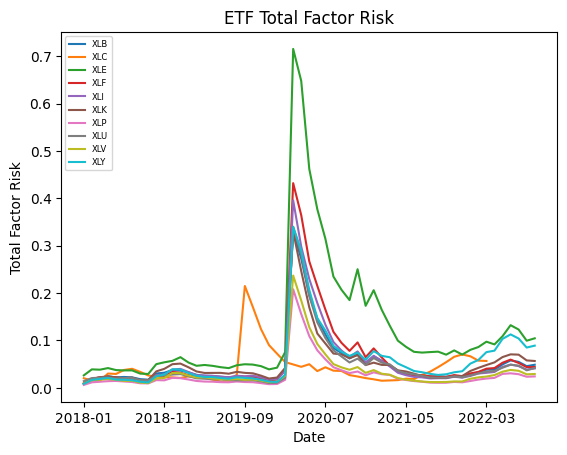

In [14]:
ETF_risk_attributions.set_index('Date').groupby('ETF')['Total Factor Risk'].plot()
plt.title("ETF Total Factor Risk")
plt.xlabel("Date")
plt.ylabel("Total Factor Risk")
plt.legend(loc ="upper left", fontsize=6)
plt.savefig('graph.png')
plt.show()

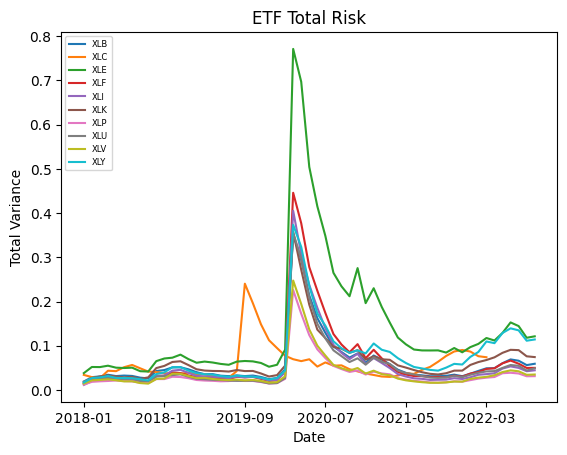

In [15]:
ETF_risk_attributions.set_index('Date').groupby('ETF')['Total Variance'].plot()
plt.title("ETF Total Risk")
plt.xlabel("Date")
plt.ylabel("Total Variance")
plt.legend(loc ="upper left", fontsize=6)
plt.savefig('graph1.png')
plt.show()

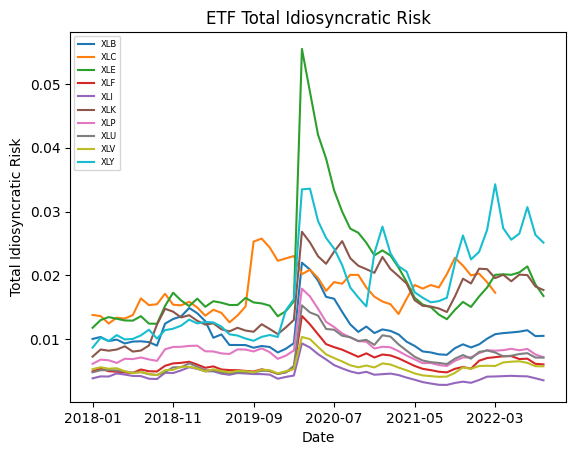

In [16]:
ETF_risk_attributions.set_index('Date').groupby('ETF')['Total Idio Risk'].plot()
plt.title("ETF Total Idiosyncratic Risk")
plt.xlabel("Date")
plt.ylabel("Total Idiosyncratic Risk")
plt.legend(loc ="upper left", fontsize=6)
plt.savefig('graph2.png')
plt.show()


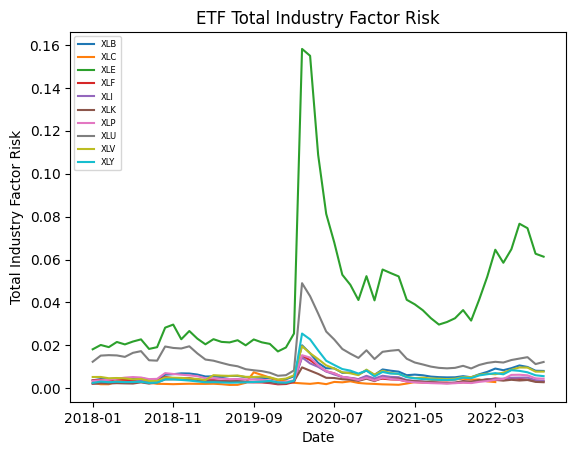

In [17]:
ETF_risk_attributions.set_index('Date').groupby('ETF')['Total Industry Factor Risk'].plot()
plt.title("ETF Total Industry Factor Risk")
plt.xlabel("Date")
plt.ylabel("Total Industry Factor Risk")
plt.legend(loc ="upper left", fontsize=6)
plt.savefig('graph3.png')
plt.show()

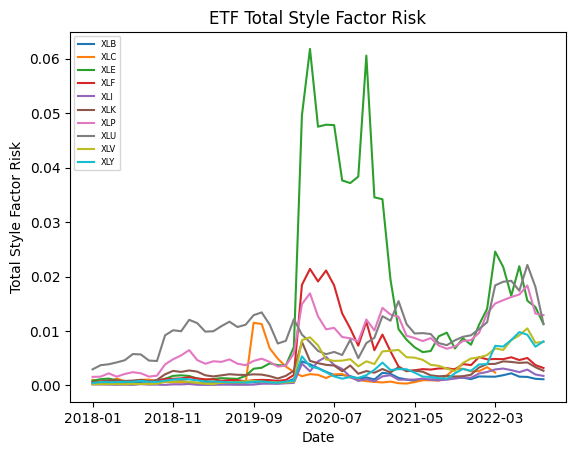

In [18]:
ETF_risk_attributions.set_index('Date').groupby('ETF')['Total Style Factor Risk'].plot()
plt.title("ETF Total Style Factor Risk")
plt.xlabel("Date")
plt.ylabel("Total Style Factor Risk")
plt.legend(loc ="upper left", fontsize=6)
plt.savefig('graph4.png')
plt.show()

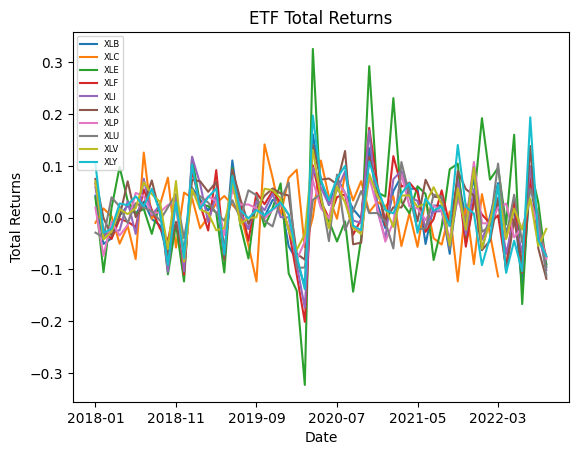

<Figure size 2500x3000 with 0 Axes>

In [19]:
ETF_performance_attributions.set_index('Date').groupby('ETF')['ETF Total Returns'].plot()
plt.title("ETF Total Returns")
plt.xlabel("Date")
plt.ylabel("Total Returns")
plt.legend(loc ="upper left", fontsize=6)
plt.figure(figsize=(25, 30))
plt.show()


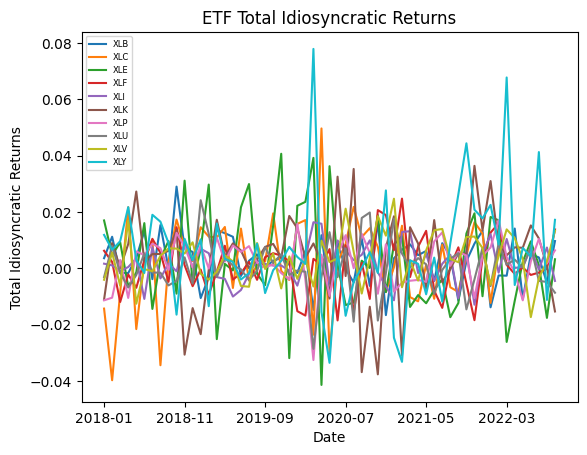

<Figure size 2500x3000 with 0 Axes>

In [20]:
ETF_performance_attributions.set_index('Date').groupby('ETF')['ETF Total Idio Returns'].plot()
plt.title("ETF Total Idiosyncratic Returns")
plt.xlabel("Date")
plt.ylabel("Total Idiosyncratic Returns")
plt.legend(loc ="upper left", fontsize=6)
plt.figure(figsize=(25, 30))
plt.show()


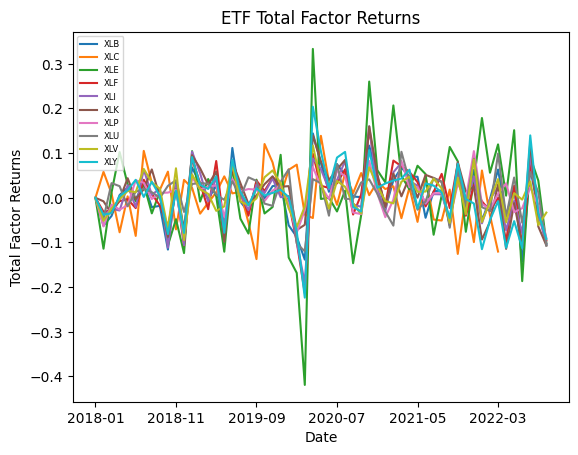

<Figure size 2500x3000 with 0 Axes>

In [21]:
ETF_performance_attributions.set_index('Date').groupby('ETF')['ETF Total Factor Return'].plot()
plt.title("ETF Total Factor Returns")
plt.xlabel("Date")
plt.ylabel("Total Factor Returns")
plt.legend(loc ="upper left", fontsize=6)
plt.figure(figsize=(25, 30))
plt.show()


In [22]:
ETF_single_factor_contribution_monthly = pd.read_csv('Axioma_ETF_single_factor_contribution.csv')
ETF_single_factor_contribution_monthly

,Unnamed: 0,ETF,Factor Name,Date,Factor Type,Contribution of Single Factor to ETF Return
0,0,XLB,Aerospace & Defense,2018-01,Industry,NaN
1,1,XLE,Aerospace & Defense,2018-01,Industry,NaN
2,2,XLF,Aerospace & Defense,2018-01,Industry,NaN
3,3,XLI,Aerospace & Defense,2018-01,Industry,NaN
4,4,XLK,Aerospace & Defense,2018-01,Industry,NaN
...,...,...,...,...,...,...
50191,50191,XLK,Wireless Telecommunication Services,2022-09,Industry,0.0
50192,50192,XLP,Wireless Telecommunication Services,2022-09,Industry,0.0
50193,50193,XLU,Wireless Telecommunication Services,2022-09,Industry,0.0
50194,50194,XLV,Wireless Telecommunication Services,2022-09,Industry,0.0


In [23]:
###AXIOMA
#Make sure to run code from beginning to create .csv files that the cells will be working with!!!
#We made this since we are working with Axioma and MSCI data and didn't change variable names but instead saved results in CSVs. 
#Top 5 factors(monthly)
ETF_single_factor_contribution_monthly = pd.read_csv('Axioma_ETF_single_factor_contribution.csv').rename(columns = {'Factor Name':'Factor Names'})
ETF_single_factor_contribution_monthly_top_5 = ETF_single_factor_contribution_monthly.groupby(['ETF','Date']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).head(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_monthly_top_5 = ETF_single_factor_contribution_monthly_top_5.groupby(['ETF','Date']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Top 5 Factors to ETF Return(monthly)","Factor Names":"Top 5 Factors(monthly)"})

#Bottom 5 factors(monthly)
ETF_single_factor_contribution_monthly_bottom_5 = ETF_single_factor_contribution_monthly.groupby(['ETF','Date']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).tail(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_monthly_bottom_5 = ETF_single_factor_contribution_monthly_bottom_5.groupby(['ETF','Date']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Bottom 5 Factors to ETF Return(monthly)","Factor Names":"Bottom 5 Factors(monthly)"})

#Top 5 factors(yearly)
ETF_single_factor_contribution_year = pd.read_csv('Axioma_ETF_single_factor_contribution.csv').rename(columns = {'Factor Name':'Factor Names'})
ETF_single_factor_contribution_year['year'] = pd.DatetimeIndex(ETF_single_factor_contribution_year['Date']).year
ETF_single_factor_contribution_year = ETF_single_factor_contribution_year.groupby(by=['ETF','year','Factor Names'], as_index= True).apply( lambda x: ((1+x['Contribution of Single Factor to ETF Return']).cumprod()-1)).reset_index()
ETF_single_factor_contribution_year = ETF_single_factor_contribution_year.groupby(by=['ETF','year','Factor Names'], as_index= True)['Contribution of Single Factor to ETF Return'].last().reset_index()
ETF_single_factor_contribution_year_top_5 = ETF_single_factor_contribution_year.groupby(['ETF','year']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).head(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_year_top_5 = ETF_single_factor_contribution_year_top_5.groupby(['ETF','year']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Top 5 Factors to ETF Return(yearly)","Factor Names":"Top 5 Factors(yearly)"})

#Bottom 5 Factors(yearly)
ETF_single_factor_contribution_year_bottom_5 = ETF_single_factor_contribution_year.groupby(['ETF','year']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).tail(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_year_bottom_5 = ETF_single_factor_contribution_year_bottom_5.groupby(['ETF','year']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Bottom 5 Factors to ETF Return(yearly)","Factor Names":"Bottom 5 Factors(yearly)"})

#Final Performance DataFrame
final_ETF_performance_attributions = pd.read_csv('Axioma_ETF_performance_attributions.csv')
final_ETF_performance_attributions['year'] = pd.DatetimeIndex(final_ETF_performance_attributions['Date']).year
final_ETF_performance_attributions = final_ETF_performance_attributions.merge(ETF_single_factor_contribution_year_top_5, on = ['ETF','year']).merge(ETF_single_factor_contribution_year_bottom_5, on = ['ETF','year'])
final_ETF_performance_attributions = final_ETF_performance_attributions.merge(ETF_single_factor_contribution_monthly_top_5, on=['Date','ETF']).merge(ETF_single_factor_contribution_monthly_bottom_5, on=['Date','ETF'])
column_order = ['Date', 'year', 'ETF', 'ETF Total Returns', 'ETF Total Idio Returns',
       'ETF Total Factor Return', 'ETF Total Industry Factor Return',
       'ETF Total Style Factor Return', 
       'Total Contribution of Top 5 Factors to ETF Return(yearly)',
       'Total Contribution of Bottom 5 Factors to ETF Return(yearly)',
        'Top 5 Factors(yearly)',
       'Bottom 5 Factors(yearly)',
       'Total Contribution of Top 5 Factors to ETF Return(monthly)',
       'Total Contribution of Bottom 5 Factors to ETF Return(monthly)',
        'Top 5 Factors(monthly)',
       'Bottom 5 Factors(monthly)']
final_ETF_performance_attributions = final_ETF_performance_attributions[column_order]
final_ETF_performance_attributions.to_csv('ETF_performance_attributions(Axioma).csv')
final_ETF_performance_attributions

,Date,year,ETF,ETF Total Returns,ETF Total Idio Returns,ETF Total Factor Return,ETF Total Industry Factor Return,ETF Total Style Factor Return,Total Contribution of Top 5 Factors to ETF Return(yearly),Total Contribution of Bottom 5 Factors to ETF Return(yearly),Top 5 Factors(yearly),Bottom 5 Factors(yearly),Total Contribution of Top 5 Factors to ETF Return(monthly),Total Contribution of Bottom 5 Factors to ETF Return(monthly),Top 5 Factors(monthly),Bottom 5 Factors(monthly)
0,2018-01,2018,XLB,0.042263,0.009821,0.000000,0.000000,0.000000,0.013829,-0.224163,"Downside Risk, Crowding, Short-Term Momentum, ...","Construction Materials, Containers & Packaging...",0.000000,0.000000,"Aerospace & Defense, Air Freight & Logistics, ...","Transportation Infrastructure, Value, Volatili..."
1,2018-02,2018,XLB,-0.050854,0.000936,-0.054656,-0.020819,0.003169,0.013829,-0.224163,"Downside Risk, Crowding, Short-Term Momentum, ...","Construction Materials, Containers & Packaging...",0.005001,-0.060588,"Metals & Mining, Crowding, Downside Risk, Prof...","One-Day Reversal, Containers & Packaging, Cons..."
2,2018-03,2018,XLB,-0.039966,-0.007688,-0.031653,-0.018863,0.006327,0.013829,-0.224163,"Downside Risk, Crowding, Short-Term Momentum, ...","Construction Materials, Containers & Packaging...",0.008436,-0.038281,"One-Day Reversal, Size, Downside Risk, Earning...","Growth, Containers & Packaging, Metals & Minin..."
3,2018-04,2018,XLB,0.003880,-0.001795,0.001140,0.004617,-0.003485,0.013829,-0.224163,"Downside Risk, Crowding, Short-Term Momentum, ...","Construction Materials, Containers & Packaging...",0.008303,-0.006704,"Chemicals, Metals & Mining, Size, Growth, Crow...","Earnings Yield, Profitability, MidCap, Constru..."
4,2018-05,2018,XLB,0.023093,0.008855,0.011402,-0.011614,0.002451,0.013829,-0.224163,"Downside Risk, Crowding, Short-Term Momentum, ...","Construction Materials, Containers & Packaging...",0.028112,-0.017719,"Market Intercept, Size, Construction Materials...","Medium-Term Momentum, One-Day Reversal, MidCap..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022-05,2022,XLY,-0.044569,0.009589,-0.055120,-0.042811,-0.008441,0.015909,-0.400772,"Liquidity, Multiline Retail, Short Interest, D...","Textiles, Apparel & Luxury Goods, Downside Ris...",0.016257,-0.051786,"Automobiles, Profitability, Short-Term Momentu...","Market Sensitivity, Multiline Retail, Hotels, ..."
560,2022-06,2022,XLY,-0.103782,0.023796,-0.144355,-0.023503,-0.035239,0.015909,-0.400772,"Liquidity, Multiline Retail, Short Interest, D...","Textiles, Apparel & Luxury Goods, Downside Ris...",0.011817,-0.122350,"Value, Multiline Retail, Growth, Medium-Term M...","Market Sensitivity, One-Day Reversal, Downside..."
561,2022-07,2022,XLY,0.193778,0.061271,0.120253,0.003890,0.030399,0.015909,-0.400772,"Liquidity, Multiline Retail, Short Interest, D...","Textiles, Apparel & Luxury Goods, Downside Ris...",0.129724,-0.015556,"Market Intercept, Market Sensitivity, Automobi...","Liquidity, Growth, Multiline Retail, Downside ..."
562,2022-08,2022,XLY,-0.042726,-0.005611,-0.042306,0.003677,-0.007967,0.015909,-0.400772,"Liquidity, Multiline Retail, Short Interest, D...","Textiles, Apparel & Luxury Goods, Downside Ris...",0.029525,-0.065744,"Specialty Retail, Market Sensitivity, Liquidit...","One-Day Reversal, Short-Term Momentum, Profita..."


In [24]:
ETF_single_factor_contribution_year

,ETF,year,Factor Names,Contribution of Single Factor to ETF Return
0,XLB,2018,Aerospace & Defense,0.000000
1,XLB,2018,Air Freight & Logistics,0.000000
2,XLB,2018,Airlines,0.000000
3,XLB,2018,Auto Components,0.000000
4,XLB,2018,Automobiles,0.000000
...,...,...,...,...
4445,XLY,2022,Transportation Infrastructure,0.000000
4446,XLY,2022,Value,-0.000860
4447,XLY,2022,Volatility,-0.007608
4448,XLY,2022,Water Utilities,0.000000


In [25]:
top5_ETFS_short_term_momentum = ETF_single_factor_contribution_year[ETF_single_factor_contribution_year['Factor Names']== 'Short-Term Momentum'].groupby(['year']).apply(lambda x: x[['ETF','Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).head(5))
bottom5_ETFS_short_term_momentum =ETF_single_factor_contribution_year[ETF_single_factor_contribution_year['Factor Names']== 'Short-Term Momentum'].groupby(['year']).apply(lambda x: x[['ETF','Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).tail(5))

In [26]:
bottom5_ETFS_short_term_momentum

ETF  Contribution of Single Factor to ETF Return  \
year                                                          
2018 965   XLE                                    -0.001611   
     4080  XLY                                    -0.001776   
     520   XLC                                    -0.004466   
     3190  XLU                                    -0.004594   
     2745  XLP                                    -0.013913   
2019 4169  XLY                                    -0.005246   
     2834  XLP                                    -0.006405   
     164   XLB                                    -0.008066   
     3724  XLV                                    -0.012749   
     3279  XLU                                    -0.022348   
2020 3368  XLU                                    -0.011906   
     2923  XLP                                    -0.018414   
     4258  XLY                                    -0.022659   
     3813  XLV                                    -0.039066   
     698   XLC                                    -0.041677   
2021 2122  XLI                                    -0.003662   
     4347  XLY                                    -0.005612   
     342   XLB                                    -0.010230   
     1677  XLF                                    -0.015351   
     1232  XLE                                    -0.033402   
2022 431   XLB                                    -0.002021   
     2211  XLI                                    -0.002481   
     3991  XLV                                    -0.006212   
     4436  XLY                                    -0.006820   
     3101  XLP                                    -0.012768   

                  Factor Names  
year                            
2018 965   Short-Term Momentum  
     4080  Short-Term Momentum  
     520   Short-Term Momentum  
     3190  Short-Term Momentum  
     2745  Short-Term Momentum  
2019 4169  Short-Term Momentum  
     2834  Short-Term Momentum  
     164   Short-Term Momentum  
     3724  Short-Term Momentum  
     3279  Short-Term Momentum  
2020 3368  Short-Term Momentum  
     2923  Short-Term Momentum  
     4258  Short-Term Momentum  
     3813  Short-Term Momentum  
     698   Short-Term Momentum  
2021 2122  Short-Term Momentum  
     4347  Short-Term Momentum  
     342   Short-Term Momentum  
     1677  Short-Term Momentum  
     1232  Short-Term Momentum  
2022 431   Short-Term Momentum  
     2211  Short-Term Momentum  
     3991  Short-Term Momentum  
     4436  Short-Term Momentum  
     3101  Short-Term Momentum

In [27]:
ETF_single_factor_contribution_monthly_top_5 = ETF_single_factor_contribution_monthly.groupby(['ETF','Date']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).head(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_monthly_top_5 = ETF_single_factor_contribution_monthly_top_5.groupby(['ETF','Date']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Top 5 Factors to ETF Return(monthly)","Factor Names":"Top 5 Factors(monthly)"})


In [28]:
''#MSCI
#Top 5 factors(monthly)
ETF_single_factor_contribution_monthly = pd.read_csv('MSCI_ETF_single_factor_contribution.csv')
ETF_single_factor_contribution_monthly_top_5 = ETF_single_factor_contribution_monthly.groupby(['ETF','Date']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).head(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_monthly_top_5 = ETF_single_factor_contribution_monthly_top_5.groupby(['ETF','Date']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Top 5 Factors to ETF Return(monthly)","Factor Names":"Top 5 Factors(monthly)"})

#Bottom 5 factors(monthly)
ETF_single_factor_contribution_monthly_bottom_5 = ETF_single_factor_contribution_monthly.groupby(['ETF','Date']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).tail(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_monthly_bottom_5 = ETF_single_factor_contribution_monthly_bottom_5.groupby(['ETF','Date']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Bottom 5 Factors to ETF Return(monthly)","Factor Names":"Bottom 5 Factors(monthly)"})

#Top 5 factors(yearly)
ETF_single_factor_contribution_year = pd.read_csv('MSCI_ETF_single_factor_contribution.csv')
ETF_single_factor_contribution_year['year'] = pd.DatetimeIndex(ETF_single_factor_contribution_year['Date']).year
ETF_single_factor_contribution_year = ETF_single_factor_contribution_year.groupby(by=['ETF','year','Factor Names'], as_index= True).apply( lambda x: ((1+x['Contribution of Single Factor to ETF Return']).cumprod()-1)).reset_index()
ETF_single_factor_contribution_year = ETF_single_factor_contribution_year.groupby(by=['ETF','year','Factor Names'], as_index= True)['Contribution of Single Factor to ETF Return'].last().reset_index()
ETF_single_factor_contribution_year_top_5 = ETF_single_factor_contribution_year.groupby(['ETF','year']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).head(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_year_top_5 = ETF_single_factor_contribution_year_top_5.groupby(['ETF','year']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Top 5 Factors to ETF Return(yearly)","Factor Names":"Top 5 Factors(yearly)"})

#Bottom 5 Factors(yearly)
ETF_single_factor_contribution_year_bottom_5 = ETF_single_factor_contribution_year.groupby(['ETF','year']).apply(lambda x: x[['Contribution of Single Factor to ETF Return','Factor Names']].sort_values(by= 'Contribution of Single Factor to ETF Return', ascending=False).tail(5)).reset_index().drop(columns= ['level_2'])
ETF_single_factor_contribution_year_bottom_5 = ETF_single_factor_contribution_year_bottom_5.groupby(['ETF','year']).aggregate({'Contribution of Single Factor to ETF Return': lambda x: x.sum(), 'Factor Names': lambda x: ', '.join(list(x))}).reset_index().rename(columns={"Contribution of Single Factor to ETF Return":"Total Contribution of Bottom 5 Factors to ETF Return(yearly)","Factor Names":"Bottom 5 Factors(yearly)"})

#Final Performance DataFrame
final_ETF_performance_attributions = pd.read_csv('MSCI_ETF_performance_attributions.csv')
final_ETF_performance_attributions['year'] = pd.DatetimeIndex(final_ETF_performance_attributions['Date']).year
final_ETF_performance_attributions = final_ETF_performance_attributions.merge(ETF_single_factor_contribution_year_top_5, on = ['ETF','year']).merge(ETF_single_factor_contribution_year_bottom_5, on = ['ETF','year'])
final_ETF_performance_attributions = final_ETF_performance_attributions.merge(ETF_single_factor_contribution_monthly_top_5, on=['Date','ETF']).merge(ETF_single_factor_contribution_monthly_bottom_5, on=['Date','ETF'])
column_order = ['Date', 'year', 'ETF', 'ETF Total Returns', 'ETF Total Idio Returns',
       'ETF Total Factor Return', 'ETF Total Industry Factor Return',
       'ETF Total Style Factor Return', 
       'Total Contribution of Top 5 Factors to ETF Return(yearly)',
       'Total Contribution of Bottom 5 Factors to ETF Return(yearly)',
        'Top 5 Factors(yearly)',
       'Bottom 5 Factors(yearly)',
       'Total Contribution of Top 5 Factors to ETF Return(monthly)',
       'Total Contribution of Bottom 5 Factors to ETF Return(monthly)',
        'Top 5 Factors(monthly)',
       'Bottom 5 Factors(monthly)']
final_ETF_performance_attributions = final_ETF_performance_attributions[column_order]
final_ETF_performance_attributions.to_csv('ETF_performance_attributions(MSCI).csv')
final_ETF_performance_attributions

,Date,year,ETF,ETF Total Returns,ETF Total Idio Returns,ETF Total Factor Return,ETF Total Industry Factor Return,ETF Total Style Factor Return,Total Contribution of Top 5 Factors to ETF Return(yearly),Total Contribution of Bottom 5 Factors to ETF Return(yearly),Top 5 Factors(yearly),Bottom 5 Factors(yearly),Total Contribution of Top 5 Factors to ETF Return(monthly),Total Contribution of Bottom 5 Factors to ETF Return(monthly),Top 5 Factors(monthly),Bottom 5 Factors(monthly)
0,2018-01,2018,XLB,0.042263,0.003603,0.000000,0.000000,0.000000,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.000000,0.000000,"Aerospace and Defence, Airlines, Aluminium Ste...","Diversified Telecommunication Services, Tradin..."
1,2018-02,2018,XLB,-0.050856,0.011216,-0.062424,-0.025339,0.002098,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.005539,-0.063701,"Regional Momentum, Long Term Reversal, Momentu...","Profitability, Construction Materials, Preciou..."
2,2018-03,2018,XLB,-0.039966,-0.001648,-0.040538,-0.018411,-0.002409,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.006528,-0.040144,"Size, Residual Volatility, Precious Metals Gol...","Profitability, Regional Momentum, Containers a..."
3,2018-04,2018,XLB,0.003879,-0.001693,0.006111,0.000832,0.004730,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.015835,-0.008553,"Chemicals, Regional Momentum, Aluminium Steel,...","Construction Materials, Containers and Packain..."
4,2018-05,2018,XLB,0.023088,0.003768,0.023359,-0.000802,0.000958,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.037377,-0.016791,"Country, Chemicals, Construction Materials, Re...","Profitability, Momentum, Growth, Specialty Che..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022-05,2022,XLY,-0.044570,0.007258,-0.052241,-0.025123,-0.023602,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.013171,-0.033354,"Automobiles and Components, Growth, Profitabil...","Hotels Leisure and Consumer Services, Liquidit..."
560,2022-06,2022,XLY,-0.103782,0.004161,-0.112339,-0.009774,-0.014230,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.019301,-0.126459,"Value, Growth, Distributors and Multiline Reta...","Leverage, Internet Software and IT Services, H..."
561,2022-07,2022,XLY,0.193777,0.041307,0.139704,0.014647,0.034383,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.133457,-0.009065,"Country, Beta, Automobiles and Components, Int...","Liquidity, Internet and Catalog Retail, Short ..."
562,2022-08,2022,XLY,-0.042727,-0.011237,-0.033793,-0.000329,0.005332,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.020757,-0.057584,"Beta, Specialty Retail, Liquidity, Short Inter...","Long Term Reversal, Momentum, Profitability, A..."


Checking which factors contribute the most to the portfolio returns. 

In [29]:
final_ETF_performance_attributions[final_ETF_performance_attributions['year']==2018]['Top 5 Factors(yearly)'].unique()

array(['Residual Volatility, Short Interest, Dividend Yield, Long Term Reversal, Downside Risk',
       'Sentiment, Oil and Gas Consumable Fuels, Dividend Yield, Beta, Leverage',
       'Residual Volatility, Insurance Brokers and Reinsurance, Beta, Value, Mid Cap',
       'Health Care Equipment and Technology, Earnings Quality, Regional Momentum, Residual Volatility, Industry Momentum',
       'Software, Internet and Catalog Retail, Semiconductors, Profitability, Mid Cap',
       'Beta, Profitability, Dividend Yield, Household and Personal Products, Earnings Quality',
       'Beta, Electric Utilities, Multi-Utilities Water Utilities Power, Dividend Yield, Gas Utilities',
       'Health Care Equipment and Technology, Beta, Pharmaceuticals, Biotechnology Life Sciences, Profitability',
       'Profitability, Internet Software and IT Services, Restaurants, Growth, Momentum',
       'Media, Size, Software, Internet and Catalog Retail, Growth'],
      dtype=object)

In [30]:
industry_dumm = ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']=='Industry']['Factor Names'].unique()
style_dumm =  ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']=='Style']['Factor Names'].unique()
names = final_ETF_performance_attributions[final_ETF_performance_attributions['year']==2018]['Top 5 Factors(yearly)'].unique()
print('im',set(names) & set(style_dumm))

im set()


In [156]:
list(final_ETF_performance_attributions[final_ETF_performance_attributions['year']==2018]['Bottom 5 Factors(yearly)'].unique())

['Construction Materials, Containers & Packaging, Metals & Mining, Chemicals, Market Intercept',
 'Value, Earnings Variability, Energy Equipment & Services, Oil, Gas & Consumable Fuels, Market Intercept',
 'Capital Markets, Profitability, Value, Banks, Market Intercept',
 'One-Day Reversal, Aerospace & Defense, Machinery, Industrial Conglomerates, Market Intercept',
 'Size, One-Day Reversal, Technology Hardware, Storage & Peripherals, Market Sensitivity, Market Intercept',
 'Food & Staples Retailing, Food Products, Short-Term Momentum, Tobacco, Market Intercept',
 'Medium-Term Momentum, Value, Volatility, Profitability, Market Intercept',
 'Crowding, Size, Short Interest, Biotechnology, Market Intercept',
 'Household Durables, Market Sensitivity, Media, Leverage, Market Intercept',
 'Downside Risk, Short-Term Momentum, Earnings Variability, Market Sensitivity, Market Intercept']

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

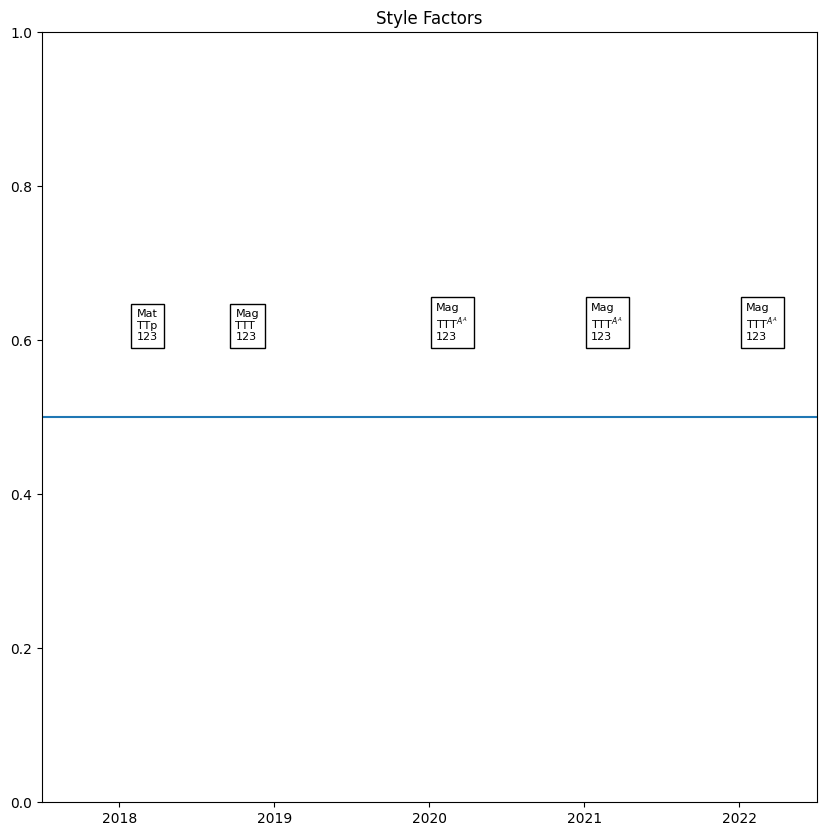

In [147]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10))



ax1.text(0.15, 0.6, "Mat\nTTp\n123", size=8,
         va="baseline", ha="right", multialignment="left",
         bbox=dict(fc="none"))

ax1.text(0.25,  0.6, "Mag\nTTT\n123", size=8,
         va="baseline", ha="left", multialignment="left",
         bbox=dict(fc="none"))

ax1.text(0.55,  0.6, "Mag\nTTT$^{A^A}$\n123", size=8,
         va="baseline", ha="right", multialignment="left",
         bbox=dict(fc="none"))

ax1.text(0.75,  0.6, "Mag\nTTT$^{A^A}$\n123", size=8,
         va="baseline", ha="right", multialignment="left",
         bbox=dict(fc="none"))

ax1.text(0.95,  0.6, "Mag\nTTT$^{A^A}$\n123", size=8,
         va="baseline", ha="right", multialignment="left",
         bbox=dict(fc="none"))

ax1.set_xticks(np.linspace(0.1,0.9,5),
               labels=final_ETF_performance_attributions['year'].unique())

ax1.axhline(0.5)
ax1.set_title("Style Factors")

plt.show()

In [134]:
df = ETF_single_factor_contribution_monthly.copy()
df = df.merge(df.groupby(['Date','ETF']).apply(lambda x: np.sum(x['Contribution of Single Factor to ETF Return'])).reset_index(), on= ['Date','ETF']).drop(columns = ['Unnamed: 0'])

df



,ETF,Factor Name,Date,Factor Type,Factor Names,Contribution of Single Factor to ETF Return,0
0,XLB,USMEDS_AERODEF,2018-01,Industry,Aerospace and Defence,NaN,0.000000
1,XLB,USMEDS_AIRLINES,2018-01,Industry,Airlines,NaN,0.000000
2,XLB,USMEDS_ALUMSTEL,2018-01,Industry,Aluminium Steel,NaN,0.000000
3,XLB,USMEDS_APPAREL,2018-01,Industry,Apparel and Textiles,NaN,0.000000
4,XLB,USMEDS_AUTO,2018-01,Industry,Automobiles and Components,NaN,0.000000
...,...,...,...,...,...,...,...
46243,XLY,USMEDS_TELECOM,2022-09,Industry,Diversified Telecommunication Services,-0.000000,-0.091923
46244,XLY,USMEDS_TRADECO,2022-09,Industry,Trading Companies and Distributors,-0.000003,-0.091923
46245,XLY,USMEDS_TRANSPRT,2022-09,Industry,Transporation Air Freight and Marine,-0.000077,-0.091923
46246,XLY,USMEDS_VALUE,2022-09,Style,Value,0.002641,-0.091923


In [63]:
np.arange(1,0.1)

array([], dtype=float64)

In [25]:
#industry_dumm = ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']=='Industry']['Factor Names'].unique()
#style_dumm =  ETF_single_factor_contribution[ETF_single_factor_contribution['Factor Type']=='Style']['Factor Names'].unique()
#print('Important Industry Factors:',set(names) & set(industry_dumm))
#print('Important Style Factors:', set(names) & set(style_dumm))



In [121]:
final_ETF_performance_attributions

,Date,year,ETF,ETF Total Returns,ETF Total Idio Returns,ETF Total Factor Return,ETF Total Industry Factor Return,ETF Total Style Factor Return,Total Contribution of Top 5 Factors to ETF Return(yearly),Total Contribution of Bottom 5 Factors to ETF Return(yearly),Top 5 Factors(yearly),Bottom 5 Factors(yearly),Total Contribution of Top 5 Factors to ETF Return(monthly),Total Contribution of Bottom 5 Factors to ETF Return(monthly),Top 5 Factors(monthly),Bottom 5 Factors(monthly)
0,2018-01,2018,XLB,0.042263,0.003603,0.000000,0.000000,0.000000,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.000000,0.000000,"Aerospace and Defence, Airlines, Aluminium Ste...","Diversified Telecommunication Services, Tradin..."
1,2018-02,2018,XLB,-0.050856,0.011216,-0.062424,-0.025339,0.002098,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.005539,-0.063701,"Regional Momentum, Long Term Reversal, Momentu...","Profitability, Construction Materials, Preciou..."
2,2018-03,2018,XLB,-0.039966,-0.001648,-0.040538,-0.018411,-0.002409,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.006528,-0.040144,"Size, Residual Volatility, Precious Metals Gol...","Profitability, Regional Momentum, Containers a..."
3,2018-04,2018,XLB,0.003879,-0.001693,0.006111,0.000832,0.004730,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.015835,-0.008553,"Chemicals, Regional Momentum, Aluminium Steel,...","Construction Materials, Containers and Packain..."
4,2018-05,2018,XLB,0.023088,0.003768,0.023359,-0.000802,0.000958,0.015747,-0.193305,"Residual Volatility, Short Interest, Dividend ...","Precious Metals Gold Mining, Containers and Pa...",0.037377,-0.016791,"Country, Chemicals, Construction Materials, Re...","Profitability, Momentum, Growth, Specialty Che..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022-05,2022,XLY,-0.044570,0.007258,-0.052241,-0.025123,-0.023602,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.013171,-0.033354,"Automobiles and Components, Growth, Profitabil...","Hotels Leisure and Consumer Services, Liquidit..."
560,2022-06,2022,XLY,-0.103782,0.004161,-0.112339,-0.009774,-0.014230,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.019301,-0.126459,"Value, Growth, Distributors and Multiline Reta...","Leverage, Internet Software and IT Services, H..."
561,2022-07,2022,XLY,0.193777,0.041307,0.139704,0.014647,0.034383,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.133457,-0.009065,"Country, Beta, Automobiles and Components, Int...","Liquidity, Internet and Catalog Retail, Short ..."
562,2022-08,2022,XLY,-0.042727,-0.011237,-0.033793,-0.000329,0.005332,0.029601,-0.380897,"Short Interest, Industry Momentum, Electric Ut...","Leisure Products Textiles Apparel and Luxury, ...",0.020757,-0.057584,"Beta, Specialty Retail, Liquidity, Short Inter...","Long Term Reversal, Momentum, Profitability, A..."


This will serve us as an indicator of when did Factor, Industry and Style returns were greater than others. 

In [119]:
df= pd.DataFrame()
df['Date'] = final_ETF_performance_attributions['Date']
df['ETF'] = final_ETF_performance_attributions['ETF']
df['Risk model returns'] = final_ETF_performance_attributions['ETF Total Idio Returns']+final_ETF_performance_attributions['ETF Total Factor Return']
df['Diffence in Returns'] = final_ETF_performance_attributions['ETF Total Returns'] - df['Risk model returns']
df = df[df['Date']!= '2018-01']
df['ETF Total Returns']=final_ETF_performance_attributions['ETF Total Returns']
df['year'] = pd.DatetimeIndex(df['Date']).year
df['ETF Total Returns cumpounded'] = df.groupby(by=['ETF','year'], as_index= True,group_keys=False, sort=False)['ETF Total Returns'].apply(lambda x: ((1+x).cumprod()-1) )
df['Risk model returns cumpounded'] = df.groupby(by=['ETF','year'], as_index= True,group_keys=False,sort=False)['Risk model returns'].apply(lambda x: ((1+x).cumprod()-1) )
df['Information ratio(yearly)']= df.groupby(by=['ETF','year'],as_index= False,group_keys=False,sort=False ).apply(lambda x: (x['Risk model returns cumpounded'].tail(1) - x['ETF Total Returns cumpounded'].tail(1))/np.std(x['ETF Total Returns']-x['Risk model returns']) )
df['Information ratio(yearly)']






1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
         ...   
559         NaN
560         NaN
561         NaN
562         NaN
563   -6.474968
Name: Information ratio(yearly), Length: 555, dtype: float64

In [ ]:
plt.plot("Risk model returns")

In [120]:
df['Information ratio(yearly)'].dropna()



11     -3.062628
23     -8.676210
35    -12.211908
47    -10.645600
59     -3.220666
71     -7.220722
83     -7.507260
95    -18.227753
107    -9.744320
113    -7.669142
125   -22.013754
137   -14.032475
149   -15.311374
161   -24.776932
173   -24.778603
185   -28.388902
197   -18.684679
209     2.381558
221    -9.693722
233   -20.792727
245   -10.706821
257    -7.134353
269    -3.596765
281    -3.401118
293    -5.006817
305     3.554944
317    -6.431146
329    -2.817632
341    -1.707631
353   -19.950929
365   -15.804735
377    -5.005566
389    -4.598511
401    -1.183106
413   -10.277277
425    -7.970593
437    -7.910278
449    -6.583653
461   -19.574407
473   -10.850867
482    -8.148390
491    -1.900963
500    -6.888136
509   -20.729121
518   -23.433159
527    -7.387753
536    -1.505569
545    -5.833123
554    -3.905497
563    -6.474968
Name: Information ratio(yearly), dtype: float64

In [67]:
df['Risk model returns cumpounded'].tail(1)

563   -0.386466
Name: Risk model returns cumpounded, dtype: float64

In [ ]:
#Information Ratio

df.groupby(['Date','ETF']).apply(lambda x: x['ETF Total Returns'] - x[''])


Risk model returns


### TRI LOCUM PORTFOLIO

In [159]:
def parse_xml(folder_name):
    files = os.listdir(folder_name+"/")
    files.remove('.DS_Store')
    print('13-F File Names:',*sorted(files), sep="\n")
    df = pd.DataFrame()
    companies = []
    cusip = []
    value = []
    shares = []
    investment_discretions = []
    title_of_class = []
    date=[]
    for file in files:
        html = open(folder_name+"/"+file).read()
        soup = BeautifulSoup(html, 'xml')
        companies.extend(str(soup.find_all('nameOfIssuer')).replace('<ns1:nameOfIssuer>','').replace('</ns1:nameOfIssuer>','').replace("[",'').replace("]",'').split(','))
        cusip.extend(str(soup.find_all('cusip')).replace('<ns1:cusip>','').replace('</ns1:cusip>','').replace("[",'').replace("]",'').split(','))
        tmp_value = str(soup.find_all('value')).replace('<ns1:value>','').replace('</ns1:value>','').replace("[",'').replace("]",'').split(',')
        value.extend([float(x)*1000 for x in tmp_value])
        tmp_shares = str(soup.find_all('sshPrnamt')).replace('<ns1:sshPrnamt>','').replace('</ns1:sshPrnamt>','').replace("[",'').replace("]",'').split(',')
        shares.extend([float(x)*1000 for x in tmp_shares]) 
        investment_discretions.extend(str(soup.find_all('investmentDiscretion')).replace('<ns1:investmentDiscretion>','').replace('</ns1:investmentDiscretion>','').replace("[",'').replace("]",'').split(','))
        title_of_class.extend(str(soup.find_all('titleOfClass')).replace('<ns1:titleOfClass>','').replace('</ns1:titleOfClass>','').replace("[",'').replace("]",'').split(','))
        date.extend(str((file+', ').replace('.xml','')*len(tmp_shares)).split(',')[:-1])
    df['Period of Report'] = date
    df['Name of Issuer']= companies
    df['Title of Class']=title_of_class
    df['CUSIP']=cusip
    df['Value(x 1000$)']=value
    df['Number of shares']=shares
    df['Investment Discretion']=investment_discretions
    
    return df

In [160]:
trilocum_holdings = parse_xml(folder_name = '13-F')
trilocum_holdings['CUSIPH'] = [str(CUSIP)[:-1] for CUSIP in list(trilocum_holdings['CUSIP'])]
trilocum_holdings['Period of Report'] = pd.to_datetime(trilocum_holdings['Period of Report'],format= '%Y-%m-%d')
Total_returns = trilocum_holdings.groupby(['Period of Report'])['Value(x 1000$)'].sum().reset_index().rename(columns={'Value(x 1000$)':'Total Return for the period'})
trilocum_holdings = trilocum_holdings.merge(Total_returns, on ='Period of Report')
trilocum_holdings["% exposure of portfolio"] = trilocum_holdings['Value(x 1000$)'] / trilocum_holdings['Total Return for the period']
trilocum_holdings

13-F File Names:
2020-12-31.xml
2021-03-31.xml
2021-06-30.xml
2021-09-30.xml
2021-12-31.xml
2022-03-31.xml
2022-06-30.xml
2022-09-30.xml


,Period of Report,Name of Issuer,Title of Class,CUSIP,Value(x 1000$),Number of shares,Investment Discretion,CUSIPH,Total Return for the period,% exposure of portfolio
0,2022-03-31,ADICET BIO INC,COM,007002108,10449000.0,5.232560e+08,SOLE,00700210,256000000.0,0.040816
1,2022-03-31,ALDEYRA THERAPEUTICS INC,COM,01438T106,6434000.0,1.447445e+09,SOLE,01438T10,256000000.0,0.025133
2,2022-03-31,ANNALY CAPITAL MANAGEMENT IN,COM,035710409,113000.0,1.605900e+07,SOLE,03571040,256000000.0,0.000441
3,2022-03-31,ARGENX SE,SPONSORED ADR,04016X101,11313000.0,3.588000e+07,SOLE,04016X10,256000000.0,0.044191
4,2022-03-31,AVEANNA HEALTHCARE HLDGS INC,COM,05356F105,37000.0,1.084800e+07,SOLE,05356F10,256000000.0,0.000145
...,...,...,...,...,...,...,...,...,...,...
326,2022-06-30,TRAVERE THERAPEUTICS INC,COM,89422G107,3926000.0,1.620140e+08,SOLE,89422G10,244210000.0,0.016076
327,2022-06-30,TRICIDA INC,COM,89610F101,7077000.0,7.311420e+08,SOLE,89610F10,244210000.0,0.028979
328,2022-06-30,WHEELS UP EXPERIENCE INC,COM CL A,96328L106,39000.0,1.989200e+07,SOLE,96328L10,244210000.0,0.000160
329,2022-06-30,X4 PHARMACEUTICALS INC,COM,98420X103,1677000.0,1.738300e+09,SOLE,98420X10,244210000.0,0.006867


In [67]:
#from sec_api import MappingApi
#import pandas as pd 

#mappingApi = MappingApi(api_key="")
#tickers =[]
#for i in range(len(trilocum_holdings['CUSIP'])):
 #   tmp = mappingApi.resolve("cusip", trilocum_holdings['CUSIP'][i])
 #   if tmp == []:
   #     tickers.append('NA')
   # else:
   #     tickers.append(tmp[0]['ticker'])
    #print('Finished',trilocum_holdings['CUSIP'][i])


In [96]:
load_data = True
wrds_id = 'ggvilava'
conn = wrds.Connection(wrds_username=wrds_id,host='wrds-pgdata.wharton.upenn.edu', port=9737)
crsp_raw = conn.raw_sql("""
                        select CoName, CUSIPH, LNDATE, TICKERH
                        from wrdssec.wciklink_names 
                        where LNDATE between '11/21/2000' and '11/21/2022' 
                        """)
conn.close()

Loading library list...
Done


In [97]:
crsp_raw=crsp_raw.rename(columns = {'cusiph':'CUSIPH'} )
crsp_raw

,coname,CUSIPH,lndate,tickerh
0,CORPORATE INCOME FUND SEVENTY NINTH SHORT TERM...,None,2014-02-10,None
1,NUVEEN TAX EXEMPT UNIT TRUST SERIES 169 NATION...,None,2001-12-20,None
2,K TRON INTERNATIONAL INC,48273010,2011-05-20,KTII
3,UC CORP,90263010,2002-09-23,5851B
4,FNW BANCORP INC,30253510,2021-02-16,FNWB
...,...,...,...,...
323903,"FUND I, A SERIES OF CAPITALX, LP",None,2022-11-17,None
323904,"LUK FUND IV, A SERIES OF DV DEALS, LP",None,2022-11-17,None
323905,"BI GAINGELS FUND II, A SERIES OF ZACHARY GINSBURG",None,2022-11-17,None
323906,"CU2 FUND II, A SERIES OF ROLL UP VEHICLES, LP",None,2022-11-17,None


In [105]:
crsp_raw.isna().sum()

coname          0
CUSIPH     783675
lndate          0
tickerh    783679
dtype: int64

In [163]:
trilocum_holdings[trilocum_holdings['Period of Report']=='2022-06-30']

,Period of Report,Name of Issuer,Title of Class,CUSIP,Value(x 1000$),Number of shares,Investment Discretion,CUSIPH,Total Return for the period,% exposure of portfolio
280,2022-06-30,23ANDME HOLDING CO CLASS A,COM,90138Q108,36000.0,1.436700e+07,SOLE,90138Q10,244210000.0,0.000147
281,2022-06-30,3M CO,COM,88579Y101,210000.0,1.619000e+06,SOLE,88579Y10,244210000.0,0.000860
282,2022-06-30,ADICET BIO INC,COM,007002108,2684000.0,1.838570e+08,SOLE,00700210,244210000.0,0.010991
283,2022-06-30,ADVANTAGE SOLUTIONS INC,COM CL A,00791N102,46000.0,1.215600e+07,SOLE,00791N10,244210000.0,0.000188
284,2022-06-30,ALIGOS THERAPEUTICS INC,COM,01626L105,35000.0,2.930200e+07,SOLE,01626L10,244210000.0,0.000143
285,2022-06-30,ALLAKOS INC,COM,01671P100,63000.0,2.002900e+07,SOLE,01671P10,244210000.0,0.000258
286,2022-06-30,ALLOGENE THERAPEUTICS INC,COM,019770106,3102000.0,2.721230e+08,SOLE,01977010,244210000.0,0.012702
287,2022-06-30,ALTIMMUNE INC,COM NEW,02155H200,6723000.0,5.746460e+08,SOLE,02155H20,244210000.0,0.027530
288,2022-06-30,AMYLYX PHARMACEUTICALS INC,COM,03237H101,1550000.0,8.045900e+07,SOLE,03237H10,244210000.0,0.006347
289,2022-06-30,ANNALY CAPITAL MANAGEMENT IN,COM,035710409,104000.0,1.766600e+07,SOLE,03571040,244210000.0,0.000426


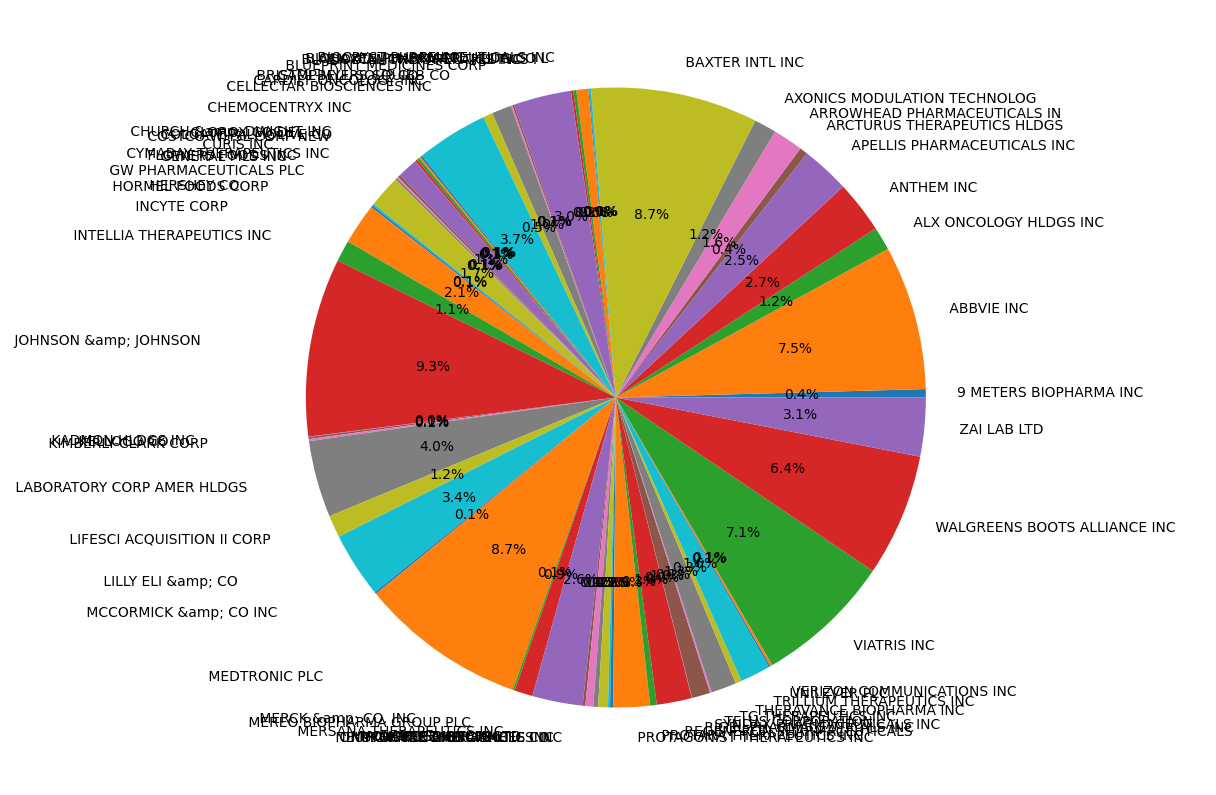

In [178]:
plt.subplots(figsize=(10, 15))
plt.pie(trilocum_holdings[trilocum_holdings['Period of Report']=='2020-12-31']['% exposure of portfolio'],
       labels = trilocum_holdings[trilocum_holdings['Period of Report']=='2020-12-31']['Name of Issuer'],
        autopct='%1.1f%%')

plt.show() 


In [103]:
trilocum_holdings.merge(crsp_raw, on = 'CUSIPH')

,Period of Report,Name of Issuer,Title of Class,CUSIP,Value(x 1000$),Number of shares,Investment Discretion,CUSIPH,Total Return for the period,% exposure of portfolio,coname,lndate,tickerh
0,2022-03-31,ADICET BIO INC,COM,007002108,10449000.0,523256000.0,SOLE,00700210,256000000.0,0.040816,"RESTORBIO, INC.",2020-08-21,ACET
1,2022-03-31,ADICET BIO INC,COM,007002108,10449000.0,523256000.0,SOLE,00700210,256000000.0,0.040816,"ADICET BIO, INC.",2022-11-15,ACET
2,2021-06-30,ALDEYRA THERAPEUTICS INC,COM,01438T106,9268000.0,818025000.0,SOLE,01438T10,305530000.0,0.030334,NEURON SYSTEMS INC,2008-08-01,ALDX
3,2021-06-30,ALDEYRA THERAPEUTICS INC,COM,01438T106,9268000.0,818025000.0,SOLE,01438T10,305530000.0,0.030334,"ALDEXA THERAPEUTICS, INC.",2014-03-04,ALDX
4,2021-06-30,ALDEYRA THERAPEUTICS INC,COM,01438T106,9268000.0,818025000.0,SOLE,01438T10,305530000.0,0.030334,"ALDEYRA THERAPEUTICS, INC.",2022-11-10,ALDX
5,2022-09-30,AKERO THERAPEUTICS INC,COM,00973Y108,7125000.0,209248000.0,SOLE,00973Y10,364337000.0,0.019556,"AKERO THERAPEUTICS, INC.",2022-11-16,AKRO
6,2021-12-31,1LIFE HEALTHCARE INC,COM,68269G107,1489000.0,84748000.0,SOLE,68269G10,254009000.0,0.005862,1LIFE HEALTHCARE INC,2022-11-17,ONEM
7,2021-09-30,AVADEL PHARMACEUTICALS PLC,SPONSORED ADR,05337M104,1454000.0,148355000.0,SOLE,05337M10,251643000.0,0.005778,FLAMEL TECHNOLOGIES SA,2016-12-30,AVDL
8,2021-09-30,AVADEL PHARMACEUTICALS PLC,SPONSORED ADR,05337M104,1454000.0,148355000.0,SOLE,05337M10,251643000.0,0.005778,AVADEL PHARMACEUTICALS PLC,2022-11-09,AVDL
9,2022-06-30,23ANDME HOLDING CO CLASS A,COM,90138Q108,36000.0,14367000.0,SOLE,90138Q10,244210000.0,0.000147,BLEECKER STREET ACQUISITION CORP.,2020-08-12,ME


In [166]:
ax.pie(trilocum_holdings[trilocum_holdings['Period of Report']=='2022-06-30']['% exposure of portfolio'], radius=1800, frame=True)


([<matplotlib.patches.Wedge at 0x7fac49b85f40>,
 [Text(1979.9997876691568, 0.9169678805591966, ''),
  Text(1979.9869711588533, 7.182899219087294, ''),
  Text(1978.347625077773, 80.87443569593168, ''),
  Text(1974.28802912158, 150.2889818557163, ''),
  Text(1974.1303548572678, 152.3461257502752, ''),
  Text(1973.9367229999064, 154.83479451464274, ''),
  Text(1965.9983574606365, 235.05416069936058, ''),
  Text(1920.6860537523185, 481.0042441822595, ''),
  Text(1858.723933247289, 682.308830350105, ''),
  Text(1843.786419345187, 721.7005194942399, ''),
  Text(1410.8272383413248, 1389.232343258028, ''),
  Text(751.7024494280649, 1831.7596533180463, ''),
  Text(749.6518831419323, 1832.5998074052488, ''),
  Text(495.17353872525376, 1917.0819404882802, ''),
  Text(82.83402924711262, 1978.2665451345756, ''),
  Text(-361.5380247642358, 1946.7126795317215, ''),
  Text(-732.3146062803586, 1839.5965094086378, ''),
  Text(-816.9951032845307, 1803.5850413022115, ''),
  Text(-1117.788722515795, 1634.3

tickers =[]
for i in range(len(trilocum_holdings['CUSIP'])):
    tmp = mappingApi.resolve("cusip", trilocum_holdings['CUSIP'][i])
    if tmp == []:
        tickers.append('NA')
    else:
        tickers.append(tmp[0]['ticker'])
    print('Finished',trilocum_holdings['CUSIP'][i])


from tabula import read_pdf
df = read_pdf('Cusip list.pdf',pages='all',pandas_options={'header': None})

#Download 13F CUSIP numbers
cusip_list = pd.DataFrame()
for i in range(len(df)):
    tmp = df[i].rename(columns={0:'CUSIP',2 :'Name of Issuer',3:'ISSUER DESCRIPTION'}).drop(columns=[1])
    tmp['CUSIP']= [x.replace(' ','') for x in tmp['CUSIP']]
    cusip_list= pd.concat([cusip_list,tmp],axis=0)
cusip_list= cusip_list.drop(columns=[4,5])
cusip_list

In [123]:
from bs4 import BeautifulSoup
import requests


In [124]:
response = requests.get('https://finance.yahoo.com/quote/TCDA/profile?p=TCDA')
soup = BeautifulSoup(response.text, "html.parser")


In [125]:
soup

<!DOCTYPE html>

<html lang="en-us"><head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta charset="utf-8"/>
<title>Yahoo</title>
<meta content="width=device-width,initial-scale=1,minimal-ui" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<style>
  html {
      height: 100%;
  }
  body {
      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;
      background-size: cover;
      height: 100%;
      text-align: center;
      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;
  }
  table {
      height: 100%;
      width: 100%;
      table-layout: fixed;
      border-collapse: collapse;
      border-spacing: 0;
      border: none;
  }
  h1 {
      font-size: 42px;
      font-weight: 400;
      color: #400090;
  }
  p {
      color: #1A1A1A;
  }
  #message-1 {
      font-weight: bold;
      margin: 0;
  }
  #message-2 {
      display: inline-block;
      *display:

In [115]:
'https://finance.yahoo.com/quote/TCDA/profile?p=TCDA'

'https://finance.yahoo.com/quote/TCDA/profile?p=TCDA'